# Movie Review Classifier:


In [1]:
import numpy as np
import pandas as pd

In [2]:
df=pd.read_csv(r"C:\Users\HP\Desktop\projects\imdb_movie_review_dataset\IMDB Dataset.csv")

In [3]:
type(df["review"][0])

str

In [4]:
import nltk

In [5]:
from nltk.tokenize import regexp_tokenize,RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from tqdm import tqdm
from keras.optimizers import RMSprop
from sklearn.preprocessing import LabelEncoder
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D ,Activation,Dropout
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping

In [6]:
tokenizer= RegexpTokenizer('[a-z]+')
ps=PorterStemmer()
s_words=set(stopwords.words("english"))


In [38]:
s_words={ps.stem(s) for s in s_words}
def Clean_review(text):
    text=text.lower()
    #tokenizer
    text= tokenizer.tokenize(text)
    
    text=[ps.stem(x) for x in text]
    text=[x for x in text if x not in s_words or x=="not"]
    
    return(" ".join(text))

In [39]:
Clean_review("the typ1_ /stori ti-say 🏫 and _ti@frro![rsdd grr dfdf hhjd ")

'typ stori ti say ti frro rsdd grr dfdf hhjd'

# Preparing data

In [40]:
from sklearn.model_selection import train_test_split

X=df["review"].copy()
Y=df["sentiment"].copy()
x_train,x_test,y_train,y_test= train_test_split(X,Y,test_size=0.2,stratify=Y,random_state=0)

In [42]:
x_train.shape,x_test.shape

((40000,), (10000,))

In [43]:

for i in range(x_train.shape[0]):
    if i %4000==0:
        print("*",end=" ")
    x_train.iloc[i]=Clean_review(x_train.iloc[i])
    

* * * * * * * * * * 

In [55]:
#for initializing tokenizer of keras and  padding

unique_words = set()
len_max = 0

for sent in tqdm([x_train.iloc[i].split() for i in range(x_train.shape[0])]):
    
    unique_words.update(sent)
    
    if(len_max<len(set(sent))):
        len_max = len(set(sent))
        
#length of the list of unique_words gives the no of unique words
print(len(list(unique_words)))
print(len_max)



  0%|                                                                                        | 0/40000 [00:00<?, ?it/s]

  8%|██████                                                                    | 3284/40000 [00:00<00:01, 32836.51it/s]

 16%|████████████                                                              | 6502/40000 [00:00<00:01, 32547.48it/s]

 23%|████████████████▉                                                         | 9179/40000 [00:00<00:01, 30491.62it/s]

 28%|████████████████████▌                                                    | 11265/40000 [00:00<00:01, 26706.84it/s]

 34%|████████████████████████▌                                                | 13485/40000 [00:00<00:01, 25111.32it/s]

 39%|████████████████████████████▌                                            | 15682/40000 [00:00<00:01, 24020.63it/s]

 47%|██████████████████████████████████▍                                      | 18876/40000 [00:00<00:00, 25905.06it/s]

 56%|█████████████████████████

62516
626


In [56]:
max_words=len(list(unique_words))
max_len = len_max
tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(x_train)
sequences = tok.texts_to_sequences(x_train)
sequences_matrix =pad_sequences(sequences,maxlen=max_len)

# Model

In [111]:
from keras.optimizers import Adam
model=Sequential()
model.add(Embedding(len(list(unique_words)),50,input_length=len_max))
model.add(LSTM(128,dropout=0.5, recurrent_dropout=0.5,return_sequences=True))
model.add(LSTM(64,dropout=0.5, recurrent_dropout=0.5,return_sequences=False))
model.add(Dense(100,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2,activation='softmax'))
model.compile(loss='categorical_crossentropy',optimizer=Adam(lr=0.005),metrics=['accuracy'])
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 626, 50)           3125800   
_________________________________________________________________
lstm_9 (LSTM)                (None, 626, 128)          91648     
_________________________________________________________________
lstm_10 (LSTM)               (None, 64)                49408     
_________________________________________________________________
dense_5 (Dense)              (None, 100)               6500      
_________________________________________________________________
dropout_6 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 2)                 202       
Total params: 3,273,558
Trainable params: 3,273,558
Non-trainable params: 0
____________________________________________

In [112]:
Le= LabelEncoder().fit(y_train)
y_train_cat=to_categorical(Le.transform(y_train))
y_test_cat=to_categorical(Le.transform(y_test))

In [114]:
history=model.fit(sequences_matrix,y_train_cat,batch_size=256,epochs=10,
          validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.0001)])

Epoch 1/10
125/125 [==============================] - 2804s 22s/step - loss: 0.4780 - accuracy: 0.7814 - val_loss: 0.3302 - val_accuracy: 0.8559


In [116]:
model.metrics_names

['loss', 'accuracy']

# Preparing Test data

In [117]:
def Processing(data):
    for i in range(data.shape[0]):
        if i%2000==0:
            print("*",end=" ")
        data.iloc[i]=Clean_review(data.iloc[i])
    test_sequences = tok.texts_to_sequences(data)
    test_sequences_matrix = pad_sequences(test_sequences,maxlen=max_len)
    
    return test_sequences_matrix

In [118]:
test_sequences_matrix=Processing(x_test)

* * * * * 

In [119]:
model.evaluate(test_sequences_matrix,y_test_cat)

313/313 [==============================] - 138s 439ms/step - loss: 0.3258 - accuracy: 0.8579


[0.3258226215839386, 0.8579000234603882]

## Accuracy

In [120]:
y_predict=model.predict(test_sequences_matrix)
y_test_=np.argmax(y_test_cat,axis=1)
y_predict=np.argmax(y_predict,axis=1)

In [121]:
acc=np.sum(y_predict==y_test_)/y_test_.shape[0]

In [122]:
acc

0.8579

## Confusion matrix

In [123]:
from sklearn.metrics import confusion_matrix

In [124]:
cm=confusion_matrix(y_test_,y_predict)
cm

array([[4353,  647],
       [ 774, 4226]], dtype=int64)

In [125]:
import seaborn as sns

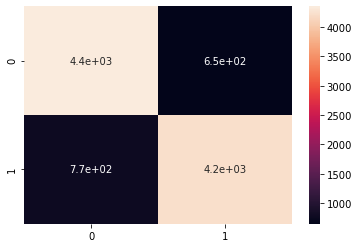

In [126]:
sns.heatmap(cm,annot=True)# we see greater diagonal values give better model

In [127]:
le_name_mapping = dict(zip( Le.transform(Le.classes_),Le.classes_))
le_name_mapping

{0: 'negative', 1: 'positive'}

In [132]:
# Testing
y_pred=model.predict(Processing(pd.Series(["very good movie","bad movie","super movie","loved it",
                                           "liked it","hated it","not good",])))
y_pred=np.argmax(y_pred,axis=1)
for i in range(y_pred.shape[0]):
    print(le_name_mapping[y_pred[i]])

* positive
negative
positive
positive
positive
negative
negative
